# Methods Notebook: Extracting Call Samples for KMeans Clustering

## Imports Section:

In [1]:
import numpy as np
import pandas as pd
import random
import scipy
from scipy import stats
import datetime as dt
import dask.dataframe as dd

In [2]:
import librosa
import warnings

In [3]:
import glob
import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [5]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from bat_detect.detector import models
from cfg import get_config
from pipeline import pipeline
from utils.utils import gen_empty_df, convert_df_ravenpro
from bat_detect.utils import wavfile
import bat_detect.utils.detector_utils as du
import bat_detect.detector.compute_features as feats
import bat_detect.detector.post_process as pp

## Function Definitions (most important functions are in `src/`)
### Below are the functions used for plotting and visualization

In [79]:
def plot_audio_seg(audio_features, spec_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()


def plot_dets_over_audio(audio_features, spec_features, plot_dets):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(10, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)

    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=1.5, edgecolor='yellow', facecolor='none', alpha=0.8)
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.ylabel("Frequency (kHz)")
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 6), 
               labels=np.linspace(0, duration, 6, dtype=plot_xtype).astype(int), rotation=0)
    plt.xlabel("Time (s)")
    plt.twinx(ax=ax)
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.ylabel("Frequency (kHz)")

    plt.show()

In [7]:
def convert_nabatdf_to_ravenprodf(df):
    raven_df = pd.DataFrame()
    raven_df['Begin Time (s)'] =  (df['peak_time_ms']-50)/1000
    raven_df['End Time (s)'] = (df['peak_time_ms']-40)/1000
    raven_df['Low Freq (Hz)'] = df['peak_freq_hz']-2000
    raven_df['High Freq (Hz)'] = df['peak_freq_hz']+2000
    raven_df['prediction'] = df['prediction']
    raven_df['score'] = df['score']
    raven_df.sort_values('Begin Time (s)', inplace=True)
    raven_df.insert(0, 'Selection', np.arange(len(raven_df)).astype(int)+1)

    raventxt_df = pd.DataFrame(np.repeat(raven_df.values, 2, axis=0))
    raventxt_df.columns = raven_df.columns
    raventxt_df['Selection'] = raventxt_df['Selection'].astype(int)
    raventxt_df.insert(1, 'Channel', [1]*raventxt_df.shape[0])
    views = np.array(['Waveform 1']*raventxt_df.shape[0], dtype='object')
    views[1::2] = 'Spectrogram 1'
    raventxt_df.insert(1, 'View', views)

    return raventxt_df

def convert_nabatdf_to_bd2df(df):
    bd2_df = pd.DataFrame()
    bd2_df['start_time'] = (df['peak_time_ms']-50)/1000
    bd2_df['end_time'] = (df['peak_time_ms']-40)/1000
    bd2_df['low_freq'] = df['peak_freq_hz']-2000
    bd2_df['high_freq'] = df['peak_freq_hz']+2000
    bd2_df['prediction'] = df['prediction']
    bd2_df['score'] = df['score']
    bd2_df.sort_values('start_time', inplace=True)
    
    return bd2_df

def convert_kaleidoscopedf_to_ravenprodf(df):
    raven_df = pd.DataFrame()
    raven_df['Begin Time (s)'] = df['OFFSET']
    raven_df['End Time (s)'] = df['OFFSET'] + df['DURATION']
    raven_df['Low Freq (Hz)'] = df['Fmin']
    raven_df['High Freq (Hz)'] = df['Fmax']
    raven_df['input_file'] = df['IN FILE']
    raven_df['input_dir'] = df['INDIR']
    raven_df['mean_freq'] = df['Fmean']
    if 'TOP1MATCH*' in df.columns:
        raven_df['TOP1MATCH*'] = df['TOP1MATCH*']
    if 'TOP1MATCH' in df.columns:
        raven_df['TOP1MATCH'] = df['TOP1MATCH']
    raven_df['TOP1DIST'] = df['TOP1DIST']
    raven_df['TOP2MATCH'] = df['TOP2MATCH']
    raven_df['TOP2DIST'] = df['TOP2DIST']
    raven_df['TOP3MATCH'] = df['TOP3MATCH']
    raven_df['TOP3DIST'] = df['TOP3DIST']
    raven_df.sort_values('Begin Time (s)', inplace=True)
    raven_df.insert(0, 'Selection', np.arange(len(raven_df)).astype(int)+1)

    raventxt_df = pd.DataFrame(np.repeat(raven_df.values, 2, axis=0))
    raventxt_df.columns = raven_df.columns
    raventxt_df['Selection'] = raventxt_df['Selection'].astype(int)
    raventxt_df.insert(1, 'Channel', [1]*raventxt_df.shape[0])
    views = np.array(['Waveform 1']*raventxt_df.shape[0], dtype='object')
    views[1::2] = 'Spectrogram 1'
    raventxt_df.insert(1, 'View', views)

    return raventxt_df

def convert_kaleidoscopedf_to_bd2df(df):
    bd2_df = pd.DataFrame()
    bd2_df['start_time'] = df['OFFSET']
    bd2_df['end_time'] = df['OFFSET'] + df['DURATION']
    bd2_df['low_freq'] = df['Fmin']
    bd2_df['high_freq'] = df['Fmax']
    bd2_df['input_file'] = df['IN FILE']
    bd2_df['input_dir'] = df['INDIR']
    bd2_df['mean_freq'] = df['Fmean']
    if 'TOP1MATCH*' in df.columns:
        bd2_df['TOP1MATCH*'] = df['TOP1MATCH*']
    if 'TOP1MATCH' in df.columns:
        bd2_df['TOP1MATCH'] = df['TOP1MATCH']
    bd2_df['TOP1DIST'] = df['TOP1DIST']
    bd2_df['TOP2MATCH'] = df['TOP2MATCH']
    bd2_df['TOP2DIST'] = df['TOP2DIST']
    bd2_df['TOP3MATCH'] = df['TOP3MATCH']
    bd2_df['TOP3DIST'] = df['TOP3DIST']
    bd2_df.sort_values('start_time', inplace=True)
    
    return bd2_df

def convert_raventxtdf_to_bd2df(raventxt_df):
    bd2_human_df = raventxt_df[::2].copy()
    bd2_human_df = bd2_human_df.drop(columns=['Selection', 'View', 'Channel'])
    bd2_human_df.rename(columns={'Begin Time (s)':'start_time',
                                'End Time (s)':'end_time',
                                'Low Freq (Hz)':'low_freq',
                                'High Freq (Hz)':'high_freq'}, inplace=True)
    bd2_human_df.sort_values('start_time', inplace=True)
    
    return bd2_human_df

In [25]:
wav_filename = '20220826_070000'
site = 'Central'
plot_file = Path(f'../../Documents/{wav_filename}/input/{wav_filename}.WAV')

In [26]:
kaleido_df = pd.read_csv(f'../../Documents/{wav_filename}/output/cluster.csv')
bd2_kaleido_df = convert_kaleidoscopedf_to_bd2df(kaleido_df)
bd2_kaleido_df

,start_time,end_time,low_freq,high_freq,input_file,input_dir,mean_freq,TOP1MATCH*,TOP1DIST,TOP2MATCH,TOP2DIST,TOP3MATCH,TOP3DIST
0,4.851936,4.854150,49390.242,57189.543,20220826_070000.WAV,/Users/adityakrishna/Documents/20220826_070000...,52390.625,nocluster,0,NaN,0,NaN,0
1,5.005365,5.006396,45977.012,47619.047,20220826_070000.WAV,/Users/adityakrishna/Documents/20220826_070000...,46551.992,nocluster,0,NaN,0,NaN,0
2,5.785726,5.786784,47905.906,51615.051,20220826_070000.WAV,/Users/adityakrishna/Documents/20220826_070000...,49152.609,nocluster,0,NaN,0,NaN,0
3,38.635807,38.641656,25236.844,27118.957,20220826_070000.WAV,/Users/adityakrishna/Documents/20220826_070000...,25987.514,nocluster,0,NaN,0,NaN,0
4,39.376575,39.379396,25157.232,26144.906,20220826_070000.WAV,/Users/adityakrishna/Documents/20220826_070000...,25527.117,nocluster,0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,1776.757446,1776.759058,41026.719,45199.184,20220826_070000.WAV,/Users/adityakrishna/Documents/20220826_070000...,42182.492,nocluster,0,NaN,0,NaN,0
556,1776.854004,1776.855824,40004.000,44200.242,20220826_070000.WAV,/Users/adityakrishna/Documents/20220826_070000...,41756.090,nocluster,0,NaN,0,NaN,0
557,1777.039062,1777.042574,39230.770,44200.242,20220826_070000.WAV,/Users/adityakrishna/Documents/20220826_070000...,40997.746,nocluster,0,NaN,0,NaN,0
558,1777.271484,1777.272512,42109.930,44444.445,20220826_070000.WAV,/Users/adityakrishna/Documents/20220826_070000...,42786.316,nocluster,0,NaN,0,NaN,0


In [27]:
nabat_df = pd.read_csv(f'../../nabat-ml-master/classify/nb__{wav_filename}.csv', index_col=0)
bd2_nabat_df = convert_nabatdf_to_bd2df(nabat_df)
bd2_nabat_df

,start_time,end_time,low_freq,high_freq,prediction,score
0,3.77375,3.78375,45000.0,49000.0,PAHE,0.398922
1,3.91450,3.92450,45000.0,49000.0,MYCA,0.566028
2,4.31100,4.32100,45000.0,49000.0,MYYU,0.812262
3,4.44550,4.45550,45000.0,49000.0,MYCA,0.416029
4,4.57675,4.58675,47000.0,51000.0,MYYU,0.482071
...,...,...,...,...,...,...
1269,1776.38325,1776.39325,39000.0,43000.0,MYLU,0.805542
1270,1776.75850,1776.76850,40000.0,44000.0,MYLU,0.834695
1271,1776.85500,1776.86500,40000.0,44000.0,MYLU,0.914673
1272,1777.04000,1777.05000,40000.0,44000.0,MYLU,0.773999


In [28]:
batdetect2_df = pd.read_csv(f'../../duty-cycle-investigation/data/raw/{site}/bd2__{site}_{wav_filename}.csv', sep=',')
batdetect2_df

,start_time,end_time,low_freq,high_freq,class,class_prob,det_prob,individual,event,input_file,Recover Folder,SD Card,Site name
0,3.7705,3.7771,45234.0,54096.0,Pipistrellus pipistrellus,0.466,0.512,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
1,4.3085,4.3140,46093.0,59238.0,Pipistrellus pipistrellus,0.512,0.542,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
2,4.8505,4.8558,45234.0,62030.0,Pipistrellus pipistrellus,0.427,0.524,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
3,5.0035,5.0094,45234.0,60073.0,Pipistrellus pipistrellus,0.489,0.538,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
4,5.1515,5.1569,46093.0,61459.0,Pipistrellus pipistrellus,0.439,0.517,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,1787.7745,1787.7849,37500.0,46675.0,Pipistrellus nathusii,0.492,0.587,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
1593,1787.9595,1787.9694,37500.0,45913.0,Pipistrellus nathusii,0.537,0.591,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
1594,1788.2125,1788.2212,39218.0,48186.0,Pipistrellus nathusii,0.431,0.544,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond
1595,1788.4135,1788.4225,40078.0,49982.0,Pipistrellus nathusii,0.441,0.566,-1,Echolocation,/mnt/ubna_data_01/recover-20220828/UBNA_010/20...,recover-20220828,UBNA_010,Central Pond


In [29]:
raventxt_human_df = pd.read_csv(f'../../Documents/Research/mila_files/mila-human-wav-txt/{wav_filename}.txt', sep='\t')
bd2_human_df = convert_raventxtdf_to_bd2df(raventxt_human_df)
bd2_human_df.reset_index(inplace=True, drop=True)
bd2_human_df

,start_time,end_time,low_freq,high_freq,Annotation,detection_confidence,input_file
0,3.770500,3.777100,45234.000,54096.000,Echolocation,0.512,20220826_070000.WAV
1,4.308500,4.314000,46093.000,59238.000,Echolocation,0.542,20220826_070000.WAV
2,4.440252,4.452032,42018.237,53398.176,e,NaN,NaN
3,4.569833,4.584558,42310.030,57191.489,v,NaN,NaN
4,4.705304,4.717084,42018.237,56316.109,e,NaN,NaN
...,...,...,...,...,...,...,...
2652,1787.774500,1787.784900,37500.000,46675.000,Echolocation,0.587,20220826_070000.WAV
2653,1787.959500,1787.969400,37500.000,45913.000,Echolocation,0.591,20220826_070000.WAV
2654,1788.212500,1788.221200,39218.000,48186.000,Echolocation,0.544,20220826_070000.WAV
2655,1788.413500,1788.422500,40078.000,49982.000,Echolocation,0.566,20220826_070000.WAV


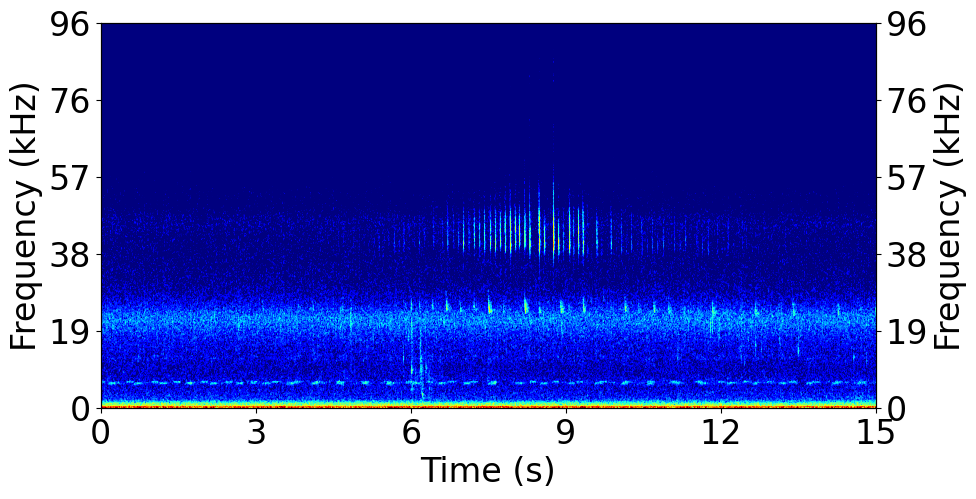

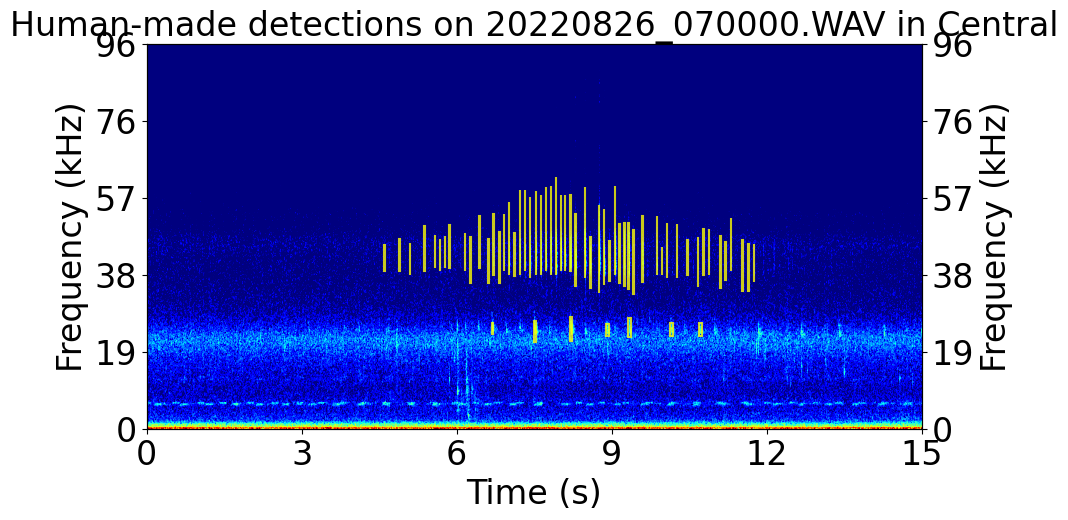

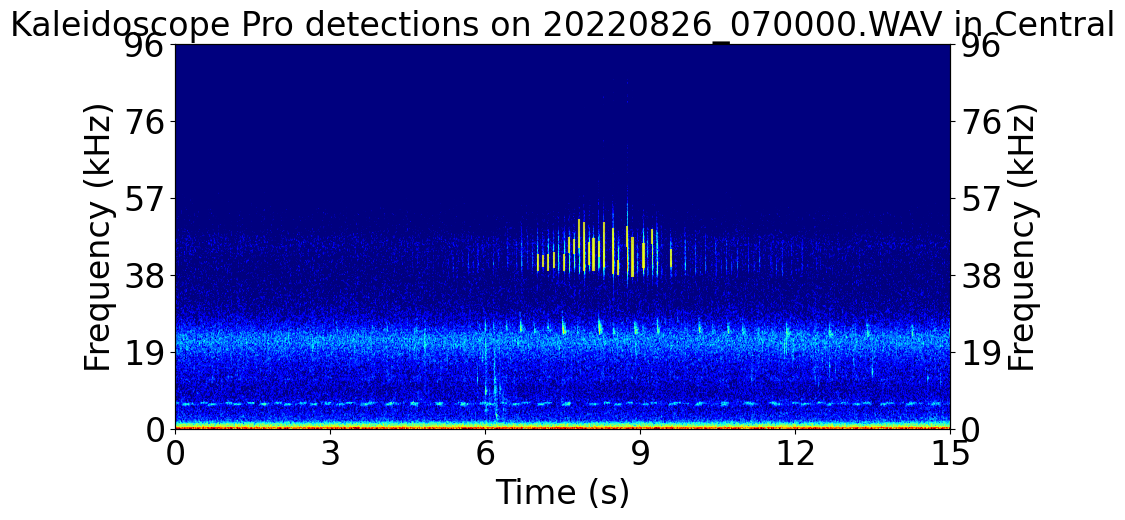

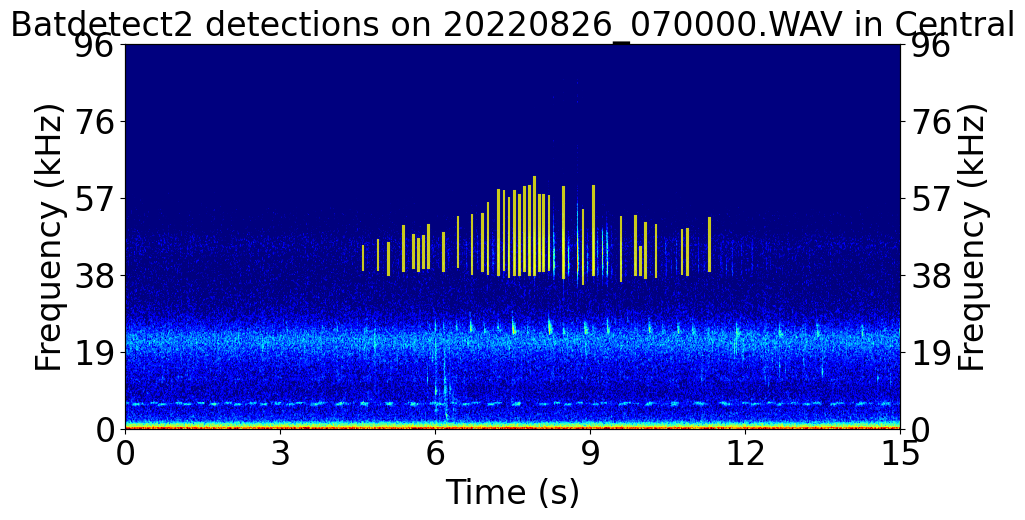

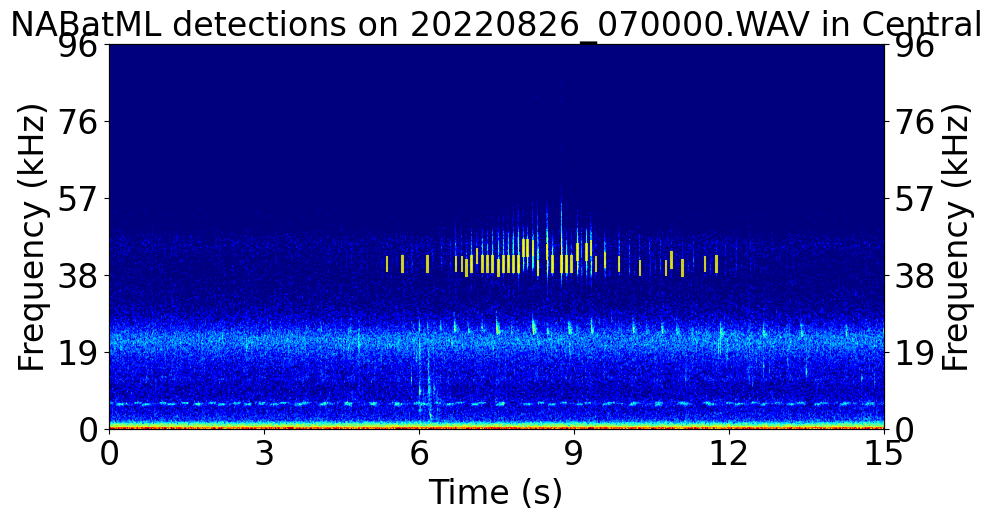

In [80]:
# Below we filter our detections dataframe to only get the detections corresponding to the above audio file
audio_file = sf.SoundFile(plot_file)
fs = audio_file.samplerate
start = 360
duration = 15
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
lower_dB = -37
upper_dB = 0
vmin = 20*np.log10(np.max(audio_seg)) + lower_dB # hide anything below lower_dB dB
vmax = 20*np.log10(np.max(audio_seg)) + upper_dB # hide anything above upper_dB dB
audio_features = dict()
audio_features['file_path'] = Path(plot_file)
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['NFFT'] = 1024 # When segments are short, NFFT should also be small to best see calls (must always be > 128)
spec_features['cmap'] = 'jet' # This colormap shows best contrast between noise and signals
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax


spec_features['plot_title'] = f""
plot_dets_over_audio(audio_features, spec_features, pd.DataFrame())
spec_features['plot_title'] = f"Human-made detections on {audio_features['file_path'].name} in {site}"
plot_dets_over_audio(audio_features, spec_features, bd2_human_df)
spec_features['plot_title'] = f"Kaleidoscope Pro detections on {audio_features['file_path'].name} in {site}"
plot_dets_over_audio(audio_features, spec_features, bd2_kaleido_df)
spec_features['plot_title'] = f"Batdetect2 detections on {audio_features['file_path'].name} in {site}"
plot_dets_over_audio(audio_features, spec_features, batdetect2_df)
spec_features['plot_title'] = f"NABatML detections on {audio_features['file_path'].name} in {site}"
plot_dets_over_audio(audio_features, spec_features, bd2_nabat_df)

In [21]:
def return_confusion_matrix_from_comparing_two_detectors(human_df, machine_df):
    false_positives = 0 ## machine made detection that human did not make
    true_positives = 0  ## machine made detection that human made
    true_negatives = 0  ## machine did not make detection that human also did not make
    false_negatives = 0 ## machine did not make detection that human made
    human_ind = 0
    machine_ind = 0

    while (human_ind < len(human_df))&(machine_ind < len(machine_df)):
        # print(human_ind, machine_ind)
        human_det = human_df.iloc[human_ind]

        machine_det = machine_df.iloc[machine_ind]

        machine_det_start_in_human_det_bounds = ((machine_det['start_time']>=human_det['start_time'])&(machine_det['start_time']<=human_det['end_time']))
        machine_det_end_in_human_det_bounds = ((machine_det['end_time']>=human_det['start_time'])&(machine_det['end_time']<=human_det['end_time']))
        human_det_start_in_machine_det_bounds = ((human_det['start_time']>=machine_det['start_time'])&(human_det['start_time']<=machine_det['end_time']))
        human_det_end_in_machine_det_bounds = ((human_det['end_time']>=machine_det['start_time'])&(human_det['end_time']<=machine_det['end_time']))

        machine_det_in_human_bounds = machine_det_start_in_human_det_bounds|machine_det_end_in_human_det_bounds
        human_det_in_machine_bounds = human_det_start_in_machine_det_bounds|human_det_end_in_machine_det_bounds

        # if human_ind>=295:
        #     print('bug')
        #     print(human_det['start_time'], human_det['end_time'])
        #     print(machine_det['start_time'], machine_det['end_time'])
        if (machine_det_in_human_bounds|human_det_in_machine_bounds):
            true_positives += 1
            machine_ind+=1
            human_ind+=1
        else:
            if (machine_det['end_time']<human_det['start_time']):
                false_positives += 1
                machine_ind+=1
            elif (machine_det['start_time']>human_det['end_time']):
                false_negatives += 1
                human_ind+=1
            else:
                true_negatives += 1

    if (machine_ind<len(machine_df)):
        false_positives += (len(machine_df) - (machine_ind))
    if (human_ind<len(human_df)):
        false_negatives += (len(human_df) - (human_ind))

    assert((true_positives+false_negatives)==len(human_df))
    assert((false_positives+true_positives)==len(machine_df))

    return {'true_positives':true_positives, 'false_positives':false_positives, 'false_negatives':false_negatives, 'true_negatives':true_negatives}

## Following the confusion matrix structure shown below

![image](example_confusion_matrix.png)

In [22]:
return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, bd2_nabat_df)

{'true_positives': 214,
 'false_positives': 5,
 'false_negatives': 458,
 'true_negatives': 0}

In [23]:
return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, bd2_kaleido_df)

{'true_positives': 82,
 'false_positives': 0,
 'false_negatives': 590,
 'true_negatives': 0}

In [24]:
return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, batdetect2_df)

{'true_positives': 344,
 'false_positives': 0,
 'false_negatives': 328,
 'true_negatives': 0}

In [26]:
file_sites = {'20220730_053000':'Carp',
 '20220727_083000':'Foliage',
 '20220829_090000':'Foliage',
 '20220826_070000':'Central'}

file_keys = list(file_sites.keys())
file_keys

['20220730_053000', '20220727_083000', '20220829_090000', '20220826_070000']

In [27]:
kaleido_cf_matrices = {'true_positives':0, 'false_positives':0, 'false_negatives':0, 'true_negatives':0}
batdetect2_cf_matrices = {'true_positives':0, 'false_positives':0, 'false_negatives':0, 'true_negatives':0}
batdetect2_mod_cf_matrices = {'true_positives':0, 'false_positives':0, 'false_negatives':0, 'true_negatives':0}
nabat_cf_matrices = {'true_positives':0, 'false_positives':0, 'false_negatives':0, 'true_negatives':0}

for file_key in file_keys:
    wav_filename = file_key
    site = file_sites[file_key]
    print(wav_filename, site)

    kaleido_df = pd.read_csv(f'../../Documents/{wav_filename}/output/cluster.csv')
    bd2_kaleido_df = convert_kaleidoscopedf_to_bd2df(kaleido_df)

    raventxt_human_df = pd.read_csv(f'../../Documents/Research/mila_files/mila-human-wav-txt/{wav_filename}.txt', sep='\t')
    bd2_human_df = convert_raventxtdf_to_bd2df(raventxt_human_df)
    bd2_human_df.reset_index(inplace=True, drop=True)

    batdetect2_df = pd.read_csv(f'../../duty-cycle-investigation/data/raw/{site}/bd2__{site}_{wav_filename}.csv', sep=',')

    nabat_df = pd.read_csv(f'../../nabat-ml-master/classify/nb__{wav_filename}.csv', index_col=0)
    bd2_nabat_df = convert_nabatdf_to_bd2df(nabat_df)

    print('Kaleidoscope confusion matrix')
    file_kaleido_cf = return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, bd2_kaleido_df)
    print(file_kaleido_cf)
    kaleido_cf_matrices['true_positives'] += file_kaleido_cf['true_positives']
    kaleido_cf_matrices['false_positives'] += file_kaleido_cf['false_positives']
    kaleido_cf_matrices['false_negatives'] += file_kaleido_cf['false_negatives']
    kaleido_cf_matrices['true_negatives'] += file_kaleido_cf['true_negatives']

    print('Batdetect2 confusion matrix')
    file_batdetect2_cf = return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, batdetect2_df)
    print(file_batdetect2_cf)
    batdetect2_cf_matrices['true_positives'] += file_batdetect2_cf['true_positives']
    batdetect2_cf_matrices['false_positives'] += file_batdetect2_cf['false_positives']
    batdetect2_cf_matrices['false_negatives'] += file_batdetect2_cf['false_negatives']
    batdetect2_cf_matrices['true_negatives'] += file_batdetect2_cf['true_negatives']

    print('Batdetect2-mod confusion matrix')
    file_batdetect2_mod_cf = return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, batdetect2_df_mod)
    print(file_batdetect2_cf)
    batdetect2_mod_cf_matrices['true_positives'] += file_batdetect2_mod_cf['true_positives']
    batdetect2_mod_cf_matrices['false_positives'] += file_batdetect2_mod_cf['false_positives']
    batdetect2_mod_cf_matrices['false_negatives'] += file_batdetect2_mod_cf['false_negatives']
    batdetect2_mod_cf_matrices['true_negatives'] += file_batdetect2_mod_cf['true_negatives']

    print('NABatML confusion matrix')
    file_nabat_cf = return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, bd2_nabat_df)
    print(file_nabat_cf)
    nabat_cf_matrices['true_positives'] += file_nabat_cf['true_positives']
    nabat_cf_matrices['false_positives'] += file_nabat_cf['false_positives']
    nabat_cf_matrices['false_negatives'] += file_nabat_cf['false_negatives']
    nabat_cf_matrices['true_negatives'] += file_nabat_cf['true_negatives']

20220730_053000 Carp
Kaleidoscope confusion matrix
{'true_positives': 82, 'false_positives': 0, 'false_negatives': 590, 'true_negatives': 0}
Batdetect2 confusion matrix
{'true_positives': 344, 'false_positives': 0, 'false_negatives': 328, 'true_negatives': 0}
Batdetect2-mod confusion matrix
{'true_positives': 344, 'false_positives': 0, 'false_negatives': 328, 'true_negatives': 0}
NABatML confusion matrix
{'true_positives': 214, 'false_positives': 5, 'false_negatives': 458, 'true_negatives': 0}
20220727_083000 Foliage
Kaleidoscope confusion matrix
{'true_positives': 1, 'false_positives': 0, 'false_negatives': 122, 'true_negatives': 0}
Batdetect2 confusion matrix
{'true_positives': 22, 'false_positives': 1, 'false_negatives': 101, 'true_negatives': 0}
Batdetect2-mod confusion matrix
{'true_positives': 22, 'false_positives': 1, 'false_negatives': 101, 'true_negatives': 0}
NABatML confusion matrix
{'true_positives': 0, 'false_positives': 3, 'false_negatives': 123, 'true_negatives': 0}
2022

In [28]:
kaleido_cf_matrices

{'true_positives': 645,
 'false_positives': 17,
 'false_negatives': 2918,
 'true_negatives': 0}

In [29]:
batdetect2_cf_matrices

{'true_positives': 2001,
 'false_positives': 1,
 'false_negatives': 1562,
 'true_negatives': 0}

In [30]:
batdetect2_mod_cf_matrices

{'true_positives': 531,
 'false_positives': 1617,
 'false_negatives': 3032,
 'true_negatives': 0}

In [31]:
nabat_cf_matrices

{'true_positives': 1405,
 'false_positives': 126,
 'false_negatives': 2158,
 'true_negatives': 0}